#Understanding Sparse Coding: From Visual Processing to Modern AI
This notebook walks through the key concepts of sparse coding, based on the [influential 1997 paper](https://www.sciencedirect.com/science/article/pii/S0042698997001697) by Olshausen and Field, and connects these ideas to modern AI interpretability.

##1. Introduction to Sparse Coding
Sparse coding is a technique for finding efficient representations of data where most components are zero or near-zero.

The key idea is that complex data (like images) can be represented as a combination of a small number of basic building blocks. For example, you can imagine that an image may be made up of many different types of edges.

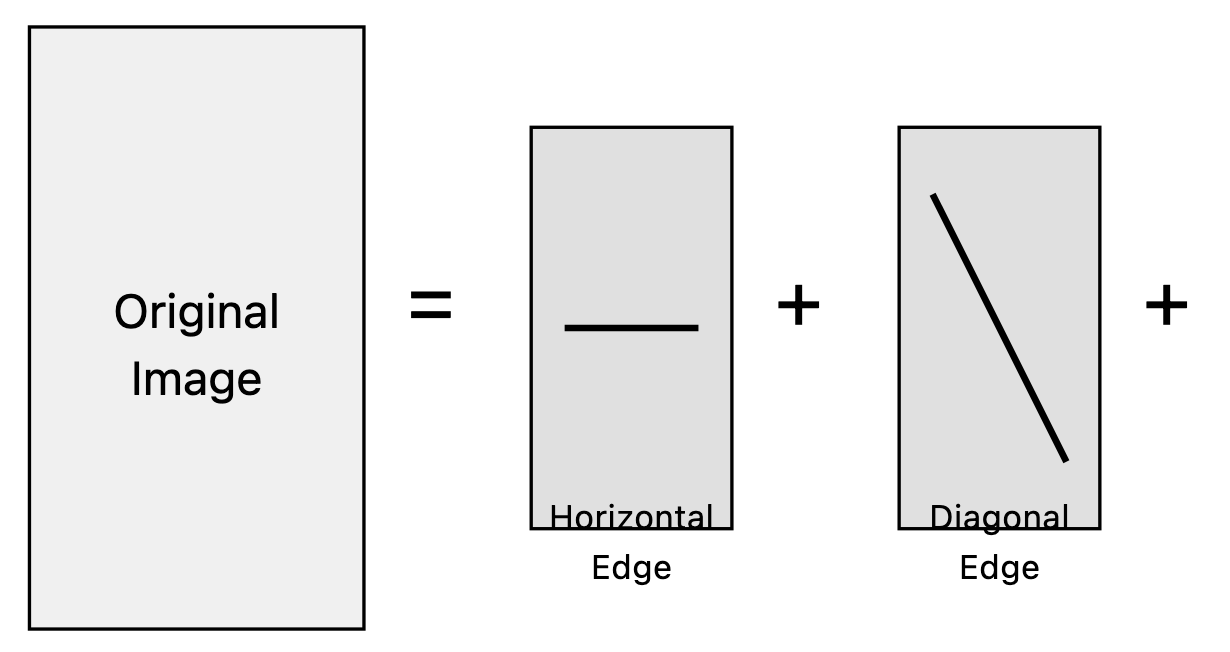

In [37]:
from IPython.display import display, HTML
from IPython.display import Image as Im
display(Im('edges_example.png', height=300, width=600))

In this paper, the building blocks of images are **basis functions**.

A basis function is, mathematically speaking, part of a set of functions that have two key properties:

1. Linearly Independent: Each basis function cannot be created by combining the others
2. Spanning: Together, they can be used to construct (or approximate) any function/signal in your space of interest

While some of these basis functions are edge detectors, many other different types of basis functions can form a complete set to describe an image.

Below is an example of a set of basis functions.

Some Example Basis Functions:


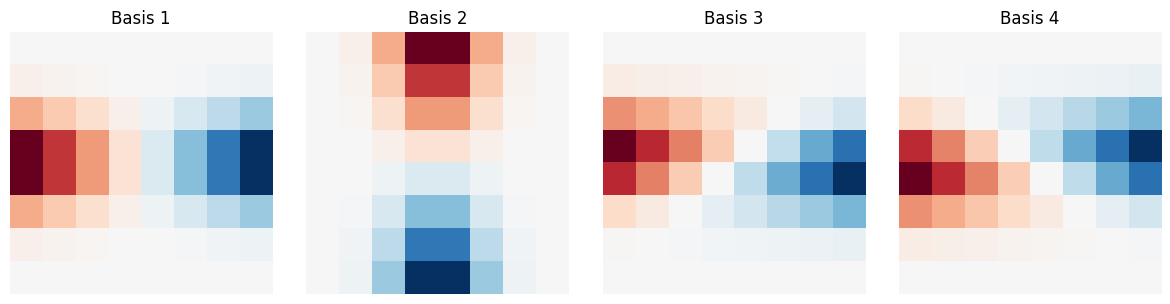

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Set random seed for reproducibility
np.random.seed(42)

def create_simple_basis_functions(size=8):
    """Create simple edge detector basis functions"""
    basis = np.zeros((4, size, size))

    # Horizontal edge
    basis[0] = signal.windows.gaussian(size, std=1)[None].T * np.linspace(-1, 1, size)

    # Vertical edge
    basis[1] = signal.windows.gaussian(size, std=1)[None] * np.linspace(-1, 1, size)[:, None]

    # Diagonal edges
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    basis[2] = signal.windows.gaussian(size, std=1)[None].T * (x + y)
    basis[3] = signal.windows.gaussian(size, std=1)[None].T * (x - y)

    return basis

# Create and display basis functions
basis_functions = create_simple_basis_functions()

print("Some Example Basis Functions:")
plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(basis_functions[i], cmap='RdBu')
    plt.title(f'Basis {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Image Reconstruction with Sparse Coding

Image reconstruction is the process of compiling an image from simpler components. The basic principle is that every image can be represented as a sum of simpler patterns (basis functions) multiplied by coefficients:

$ Image = (a_1 × pattern_1) + (a_2 × pattern_2) + ... + (a_n × pattern_n) $

For a, coefficients, and n basis functions.

Then, the key is to find:
1. Some set of basis functions that can reconstruct a wide variety of images.

2. (Sparsity) for any image, the smallest number of those basis functions that combine to create it.

In the paper, this looks like taking an image, and attempting to reconstruct it from some set of basic image patterns. The error in the image is minimized, informing both how to update the image patterns themselves, and what coefficients were used to combine them.

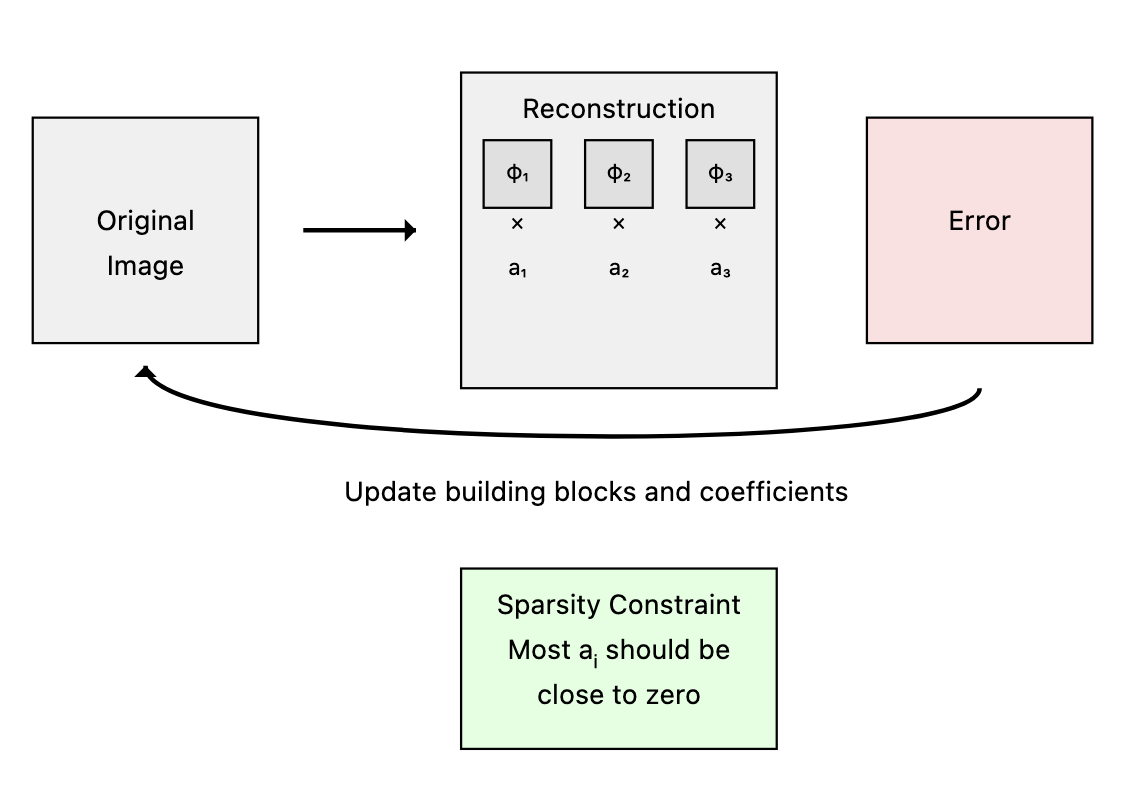

In [39]:
display(Im('reconstruction_diagram.png', height=400, width=600))

Let's see a very simple example of recontructing an image from a set of basis functions (which we'll have used to make the image in the first place, so we'll be sure it works).

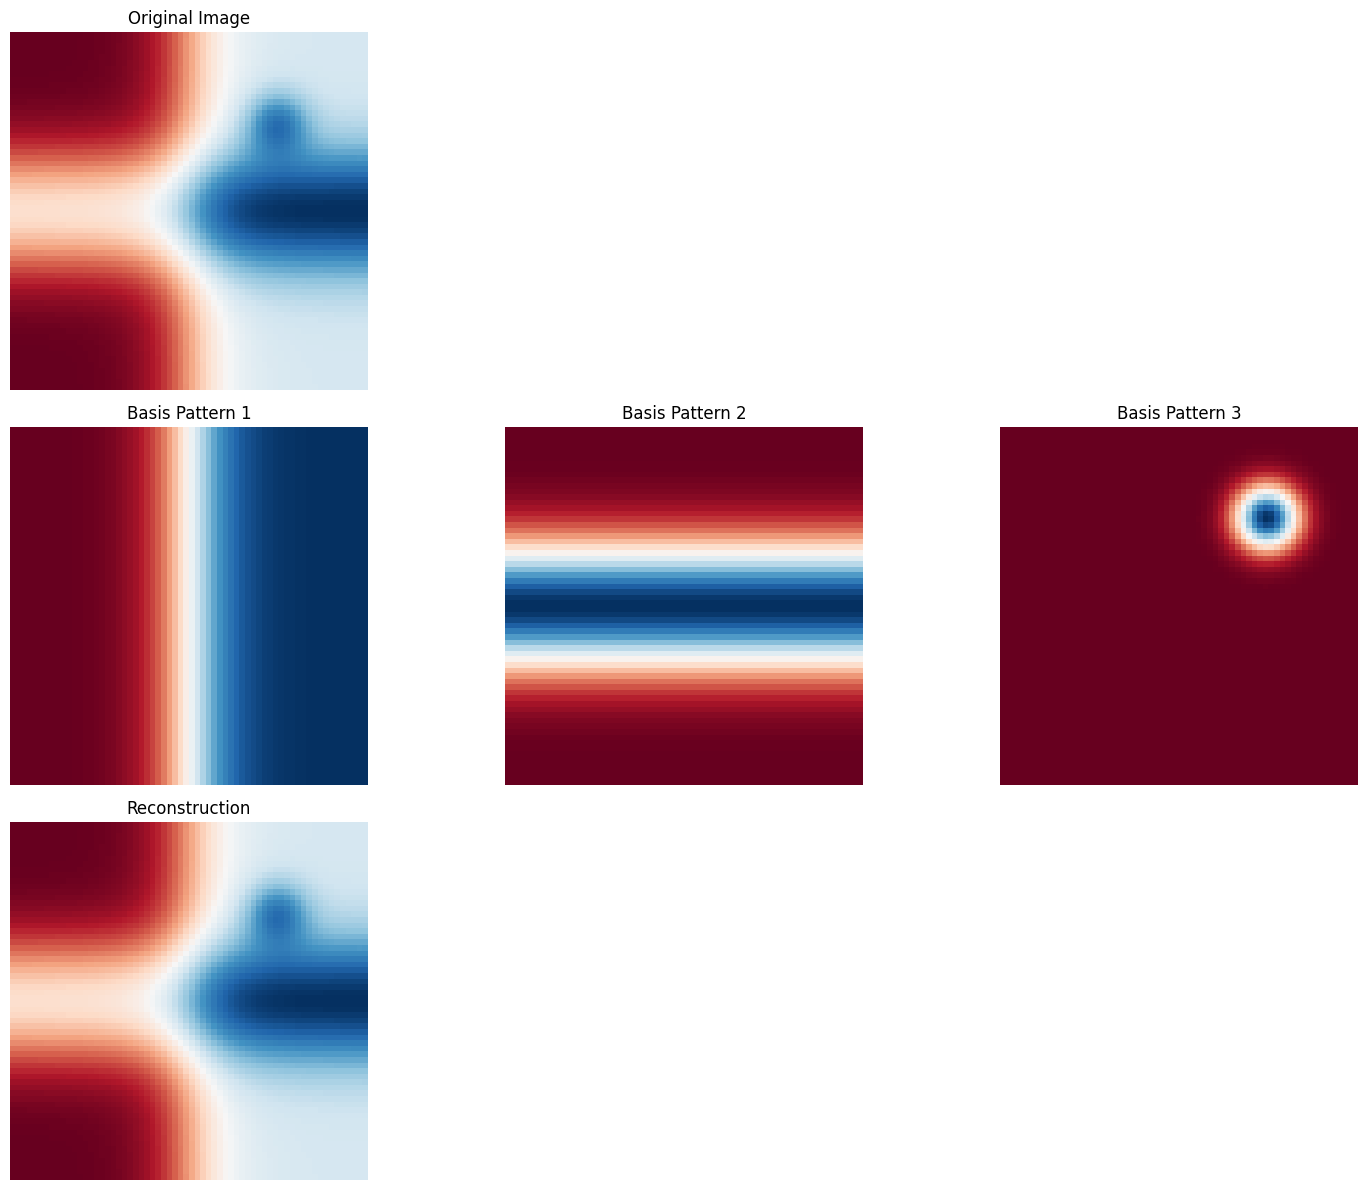

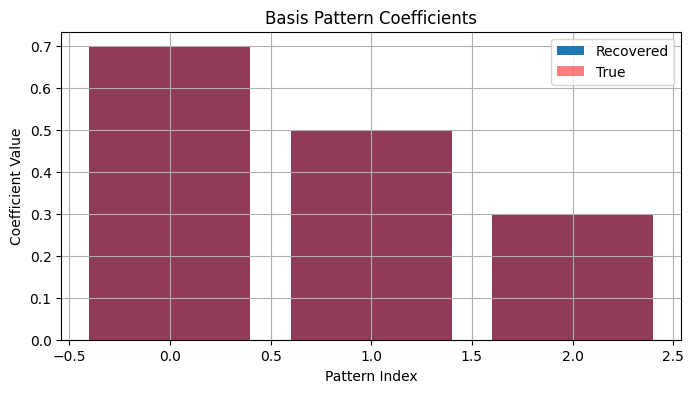

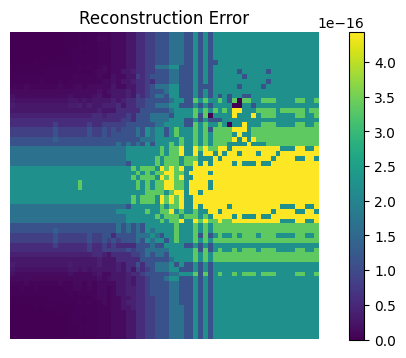

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple test image that's actually a combination of patterns
def create_test_patterns(size=64):
    x, y = np.meshgrid(np.linspace(-4, 4, size), np.linspace(-4, 4, size))

    # Pattern 1: Vertical edge
    pattern1 = 1 / (1 + np.exp(-x * 2))

    # Pattern 2: Horizontal gaussian
    pattern2 = np.exp(-y**2/2)

    # Pattern 3: Spot in upper right
    pattern3 = np.exp(-((x-2)**2 + (y+2)**2)/0.5)

    # Combine patterns with known coefficients
    true_coeffs = [0.7, 0.5, 0.3]
    test_image = (true_coeffs[0] * pattern1 +
                 true_coeffs[1] * pattern2 +
                 true_coeffs[2] * pattern3)

    return test_image, [pattern1, pattern2, pattern3], true_coeffs

# Create test image and patterns
test_image, basis_patterns, true_coeffs = create_test_patterns()

# Find coefficients using least squares
basis_2d = np.array([p.flatten() for p in basis_patterns])
coeffs = np.linalg.lstsq(basis_2d.T, test_image.flatten(), rcond=None)[0]

# Reconstruct
reconstruction = np.zeros_like(test_image)
for i, coeff in enumerate(coeffs):
    reconstruction += coeff * basis_patterns[i]

# Visualization
plt.figure(figsize=(15, 12))

# Original image
plt.subplot(331)
plt.imshow(test_image, cmap='RdBu')
plt.title('Original Image')
plt.axis('off')

# Show basis patterns
for i in range(3):
    plt.subplot(3,3,i+4)
    plt.imshow(basis_patterns[i], cmap='RdBu')
    plt.title(f'Basis Pattern {i+1}')
    plt.axis('off')

# Show reconstruction
plt.subplot(337)
plt.imshow(reconstruction, cmap='RdBu')
plt.title('Reconstruction')
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot coefficients
plt.figure(figsize=(8, 4))
plt.bar(range(len(coeffs)), coeffs)
plt.bar(range(len(true_coeffs)), true_coeffs, alpha=0.5, color='red')
plt.title('Basis Pattern Coefficients')
plt.xlabel('Pattern Index')
plt.ylabel('Coefficient Value')
plt.legend(['Recovered', 'True'])
plt.grid(True)
plt.show()

# Show reconstruction error
error = np.abs(test_image - reconstruction)
plt.figure(figsize=(8, 4))
plt.imshow(error, cmap='viridis')
plt.title('Reconstruction Error')
plt.colorbar()
plt.axis('off')
plt.show()

## 3. Understanding Overcomplete Representations
An overcomplete representation has more basis functions than necessary to span the input space.

In a way, this means that a set of overcomplete basis functions aren't mathematically "true" basis functions at all. That is, they may not all be linearly independent, and can sometimes be constructed from combinations of each other.

This is useful because it provides more flexibility in representing the data.

For any given image, not every basis function will be necessary to reconstruct it. Each basis function is like a particular "tool" - it's goal is to represent a very particular aspect of the images. When reconstructing an image, not every tool (*basis function*) is needed for every job (*image*).

To illustrate this, here's an overcomplete set of basis functions.

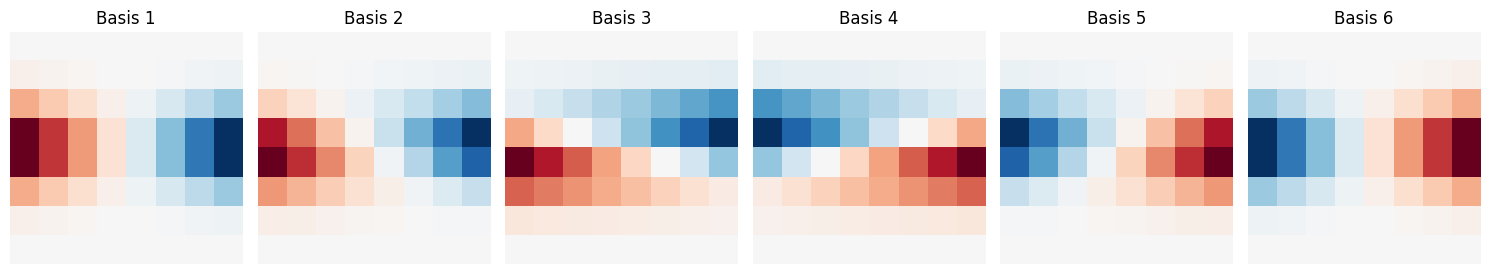

In [45]:
def create_overcomplete_basis(size=8, n_basis=6):
    """Create an overcomplete set of basis functions"""
    angles = np.linspace(0, np.pi, n_basis)
    basis = np.zeros((n_basis, size, size))

    # Create coordinate grid
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))

    for i, angle in enumerate(angles):
        x_rot = x * np.cos(angle) - y * np.sin(angle)
        basis[i] = signal.windows.gaussian(size, std=1)[None].T * x_rot

    return basis

# Create overcomplete basis
overcomplete_basis = create_overcomplete_basis()

plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(overcomplete_basis[i], cmap='RdBu')
    plt.title(f'Basis {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

We can reconstruct Basis 3 from a simple combination of 2 and 4.

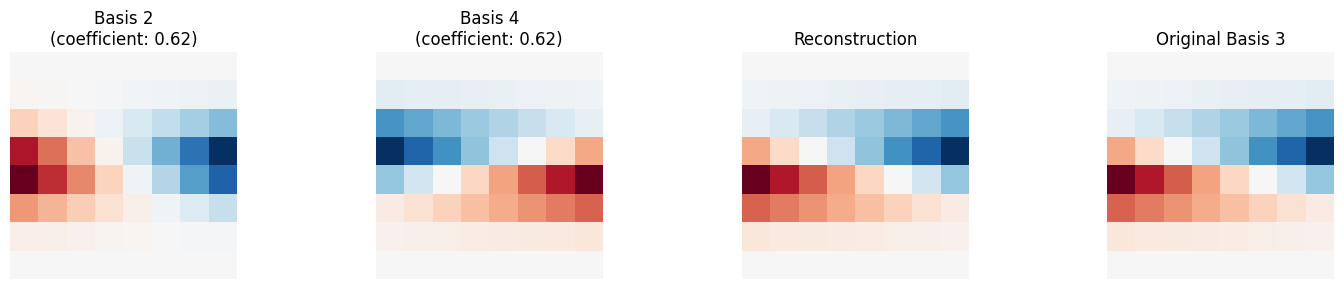

Mean squared reconstruction error: 0.000000


In [46]:
# Create basis functions
basis = create_overcomplete_basis()

# Let's try to reconstruct basis[2] (third basis function) using basis[1] and basis[3]
# We'll solve the equation: a*basis[1] + b*basis[3] ≈ basis[2]

# Flatten the basis functions for easier computation
flat_basis = basis.reshape(6, -1)

# Try to find coefficients to reconstruct basis[2]
target = flat_basis[2]
A = np.vstack([flat_basis[1], flat_basis[3]]).T
coeffs = np.linalg.lstsq(A, target, rcond=None)[0]

# Reconstruct
reconstruction = coeffs[0] * basis[1] + coeffs[1] * basis[3]

# Visualize the results
plt.figure(figsize=(15, 3))

plt.subplot(141)
plt.imshow(basis[1], cmap='RdBu')
plt.title(f'Basis 2\n(coefficient: {coeffs[0]:.2f})')
plt.axis('off')

plt.subplot(142)
plt.imshow(basis[3], cmap='RdBu')
plt.title(f'Basis 4\n(coefficient: {coeffs[1]:.2f})')
plt.axis('off')

plt.subplot(143)
plt.imshow(reconstruction, cmap='RdBu')
plt.title('Reconstruction')
plt.axis('off')

plt.subplot(144)
plt.imshow(basis[2], cmap='RdBu')
plt.title('Original Basis 3')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Mean squared reconstruction error: {np.mean((basis[2] - reconstruction)**2):.6f}")

## 4. Sparsity in Action

If a set is overcomplete, then by definition, we don't need every basis function to represent our image.

Sparsity explicitly tries to minimize the number of non-zero coefficients when combining basis functions to make an image. The goal is to find the smallest possible number of basis functions that can be combined to still create the image reconstruction.

Our distribution of coefficients, before vs after enforcing sparsity, may look like:

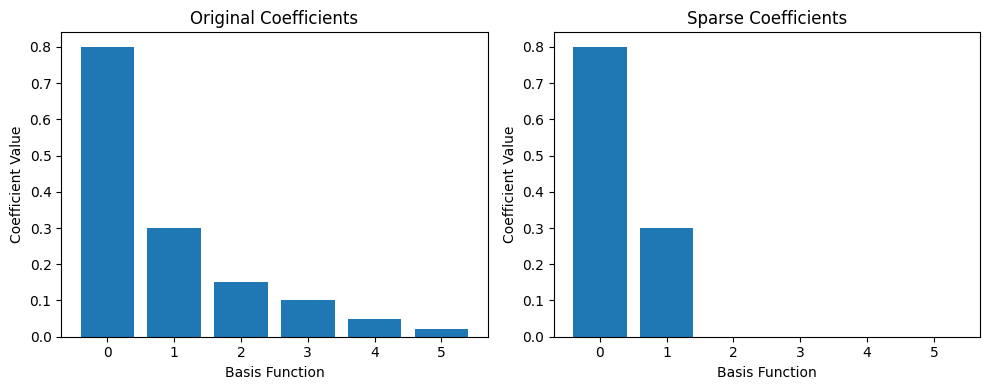

In [6]:
def apply_sparsity(coefficients, threshold=0.2):
    """Apply simple threshold-based sparsification"""
    sparse_coeffs = coefficients.copy()
    sparse_coeffs[np.abs(sparse_coeffs) < threshold] = 0
    return sparse_coeffs

# Generate some example coefficients
original_coeffs = np.array([0.8, 0.3, 0.15, 0.1, 0.05, 0.02])
sparse_coeffs = apply_sparsity(original_coeffs)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.bar(range(6), original_coeffs)
plt.title('Original Coefficients')
plt.xlabel('Basis Function')
plt.ylabel('Coefficient Value')

plt.subplot(122)
plt.bar(range(6), sparse_coeffs)
plt.title('Sparse Coefficients')
plt.xlabel('Basis Function')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

## 5. Types of Learned Basis Functions
The basis functions learned in this paper were diverse, including:

- Edge detectors at different orientations
- Bar detectors (like edges but with a finite length)
- Localized "blobs" or spots
- Some low-frequency patterns that cover larger areas

These function types had varying:

- Spatial frequency (some detect fine details, others coarser patterns)
- Orientation (different angles)
- Location within the patch
- Size/extent of the receptive field

A key finding of the paper was that these basis functions emerged naturally from optimizing for sparse coding of natural images. This was significant because:

1. They matched well with what neuroscientists had observed in actual brain cells (particularly in area V1 of the visual cortex)
2. The diversity of patterns suggested that the visual system needs different types of detectors to efficiently encode natural scenes
3. The spatial organization showed a kind of "tiling" of the visual field at different scales and orientations, which makes sense for efficient visual processing
4. At higher spatial frequencies (finer details), they found more basis functions oriented horizontally and vertically than at oblique angles, which matches both natural image statistics and human visual perception

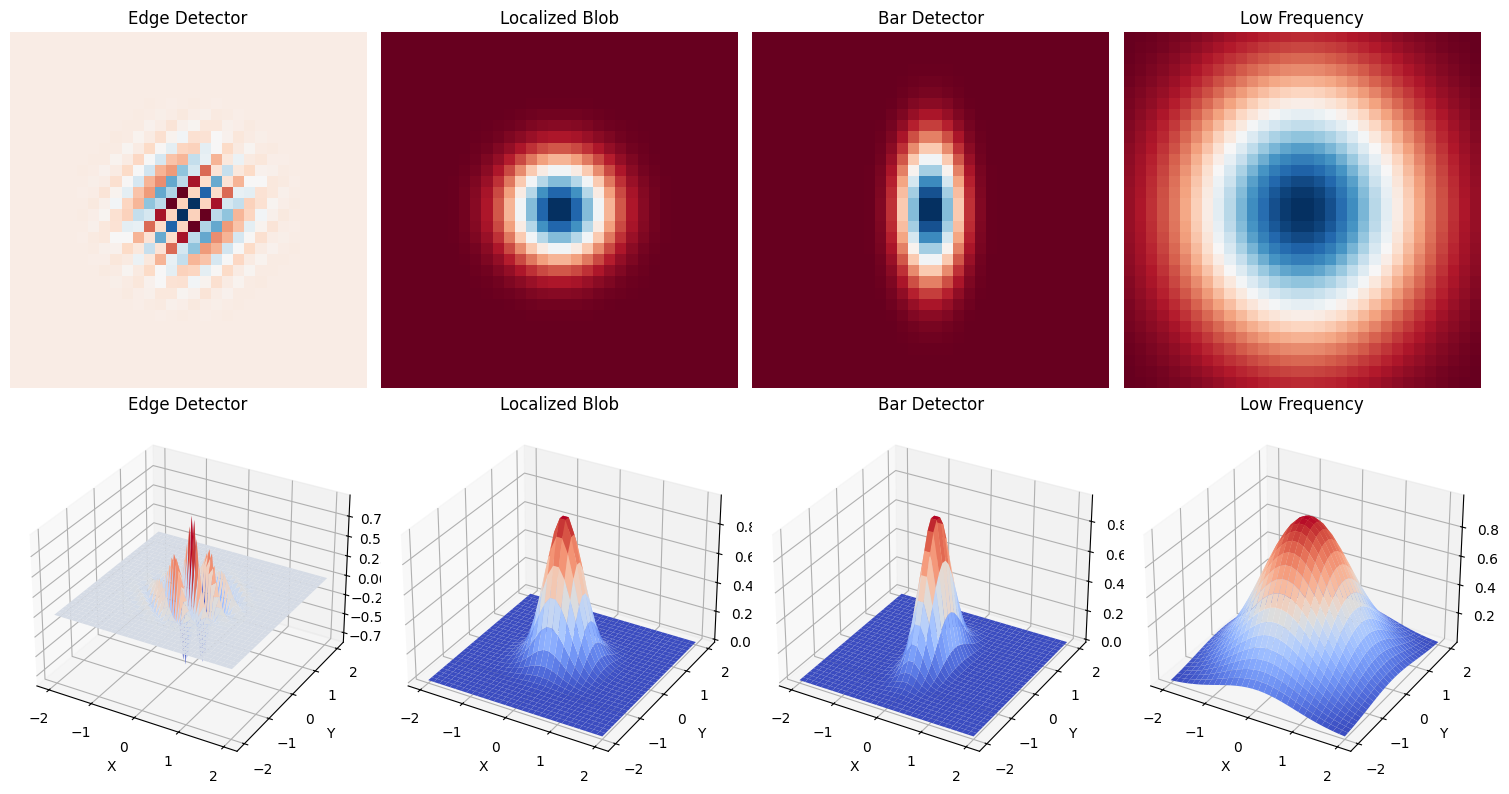

In [47]:
def create_example_basis_functions(size=32):
    basis = {}
    x = np.linspace(-2, 2, size)
    xx, yy = np.meshgrid(x, x)

    # 1. Edge detector (oriented Gabor)
    theta = np.pi / 4
    freq = 3
    sigma = 0.4
    x_theta = xx * np.cos(theta) + yy * np.sin(theta)
    y_theta = -xx * np.sin(theta) + yy * np.cos(theta)
    edge = np.exp(-(x_theta**2 + y_theta**2) / (2*sigma**2)) * np.cos(2*np.pi*freq*x_theta)
    basis['Edge Detector'] = edge

    # 2. Localized blob
    blob = np.exp(-(xx**2 + yy**2) / 0.3)
    basis['Localized Blob'] = blob

    # 3. Bar detector (more localized in length than edge)
    bar = np.exp(-xx**2/0.1) * np.exp(-yy**2/0.5)
    basis['Bar Detector'] = bar

    # 4. Low frequency pattern
    low_freq = np.cos(xx/2) * np.exp(-(xx**2 + yy**2) / 2)
    basis['Low Frequency'] = low_freq

    return basis

# Create and display examples of different types
basis_functions = create_example_basis_functions()

plt.figure(figsize=(15, 8))
# 2D view
for i, (name, basis) in enumerate(basis_functions.items(), 1):
    plt.subplot(2, 4, i)
    plt.imshow(basis, cmap='RdBu')
    plt.title(name)
    plt.axis('off')

# 3D view
for i, (name, basis) in enumerate(basis_functions.items(), 1):
    ax = plt.subplot(2, 4, i+4, projection='3d')
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)
    ax.plot_surface(X, Y, basis, cmap='coolwarm')
    ax.set_title(name)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
plt.tight_layout()
plt.show()

## 5. Connection to Modern AI Interpretability
The principles of sparse coding are highly relevant to modern AI interpretability, particularly in understanding large language models:

1. Feature Discovery: Just as sparse coding reveals basic visual features (edges, orientations), modern techniques like sparse autoencoders aim to discover fundamental features in language model representations.
2. Interpretability through Sparsity: The core insight that sparse representations tend to be more interpretable remains crucial in modern AI research.
3. Overcomplete Representations: Modern language models also use overcomplete representations, allowing for more flexible and robust processing of information.
4. Activation Patterns: The idea that complex inputs can be represented by a small number of active components helps us understand how neural networks process information.

Example application to language model interpretation:

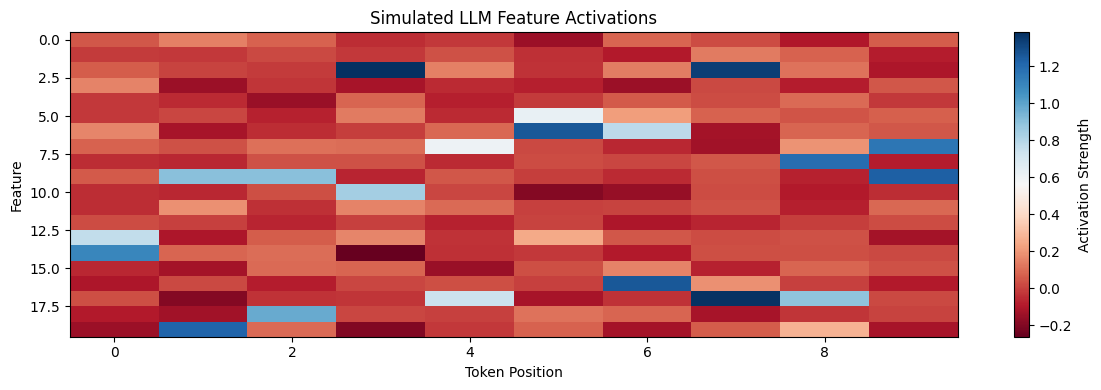

In [7]:
def simulate_llm_activation(input_tokens=10, features=20):
    """Simulate LLM feature activation patterns"""
    activations = np.random.normal(0, 0.1, (input_tokens, features))
    # Add sparse strong activations
    for i in range(input_tokens):
        active_features = np.random.choice(features, 2, replace=False)
        activations[i, active_features] = np.random.normal(1, 0.2, 2)
    return activations

# Simulate and visualize LLM activations
activations = simulate_llm_activation()

plt.figure(figsize=(12, 4))
plt.imshow(activations.T, cmap='RdBu', aspect='auto')
plt.title('Simulated LLM Feature Activations')
plt.xlabel('Token Position')
plt.ylabel('Feature')
plt.colorbar(label='Activation Strength')
plt.tight_layout()
plt.show()

## Summary
Sparse coding principles from the 1997 paper continue to influence modern AI interpretability:

- The idea that complex systems can be understood through their basic building blocks
- The principle that sparse representations tend to be more interpretable
- The value of overcomplete representations in providing flexibility and robustness
- The importance of finding efficient coding strategies for understanding complex systems

These concepts are being applied to understand modern language models through techniques like sparse autoencoders, helping us peek inside the "black box" of large AI systems.